In [2]:
# Cell 1 Data Preparation
print("== 1. Data Preparation ==")

import pyspark.sql.functions as F
from pyspark.sql import SparkSession

# RUN_MODE = "LOCAL"
RUN_MODE = "CLOUD"

# 1. Initialize SparkSession
# (The appName will dynamically change based on the mode)
spark = SparkSession.builder.appName(f"ProjectFrame-{RUN_MODE}").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

if RUN_MODE == "LOCAL":
    # 2a. [LOCAL Mode] Read a single CSV file for local framework testing
    print(f"== Cell 1: [LOCAL] Reading single local file ==")
    
    # --- Local path ---
    df = spark.read.csv(
        # "csv_data_01001099999.csv", 
        "csv_data_02974099999.csv",
        header=True, 
        inferSchema=True
    )

else:
    # 2b. [CLOUD Mode] Read ALL data directly from GCS 
    print(f"== Cell 1: [CLOUD] Reading all data from GCS ==")
    
    # --- Dataproc GCS path ---
    # This reads ALL CSVs from the GCS bucket folder
    df = spark.read.csv(
        "gs://dsa5208--project--2--data/csv_data/*.csv", # <--- Points to GCS, NOT HDFS
        header=True, 
        inferSchema=True
    )

# 3. Cache the data in memory for faster iterative analysis (like model training)
# This is the correct way to handle repeated reads, NOT distcp.
# df.cache()

print(f"== Cell 1: Data loading complete and cached (Mode: {RUN_MODE}) ==")

print("Check the type of each feature")
df.printSchema()

# print("== Data Preview: ==")
# df.show(5)

== 1. Data Preparation ==


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/30 18:48:20 INFO SparkEnv: Registering MapOutputTracker
25/10/30 18:48:20 INFO SparkEnv: Registering BlockManagerMaster
25/10/30 18:48:20 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
25/10/30 18:48:21 INFO SparkEnv: Registering OutputCommitCoordinator


== Cell 1: [CLOUD] Reading all data from GCS ==


== Cell 1: Data loading complete and cached (Mode: CLOUD) ==
Check the type of each feature
root
 |-- STATION: string (nullable = true)
 |-- DATE: string (nullable = true)
 |-- SOURCE: string (nullable = true)
 |-- LATITUDE: string (nullable = true)
 |-- LONGITUDE: string (nullable = true)
 |-- ELEVATION: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- REPORT_TYPE: string (nullable = true)
 |-- CALL_SIGN: string (nullable = true)
 |-- QUALITY_CONTROL: string (nullable = true)
 |-- WND: string (nullable = true)
 |-- CIG: string (nullable = true)
 |-- VIS: string (nullable = true)
 |-- TMP: string (nullable = true)
 |-- DEW: string (nullable = true)
 |-- SLP: string (nullable = true)
 |-- AA1: string (nullable = true)
 |-- AB1: string (nullable = true)
 |-- AE1: string (nullable = true)
 |-- AO1: string (nullable = true)
 |-- CF1: string (nullable = true)
 |-- CF2: string (nullable = true)
 |-- CG1: string (nullable = true)
 |-- CG2: string (nullable = true)
 |-- CG3: s

In [3]:
# Cell 2: Data Cleaning
print("=== Cell 2: Core Data Cleaning ===")

def parse_value_quality(df, col_name, missing_vals=[9999, 99999, 999999], scale=1.0):
    """Parsing strings in the 'value, quality code' format"""
    split_col = F.split(df[col_name], ',')
    value_str = split_col.getItem(0)
    quality = split_col.getItem(1)
    
    # Convert to numerical value
    value = value_str.cast('double')
    
    # Handling missing values and scaling
    cleaned = F.when(value.isin(missing_vals), None).otherwise(value / scale)
    
    return df.withColumn(f"{col_name}_value", cleaned) \
            .withColumn(f"{col_name}_quality", quality.cast('int'))

def parse_wind(df):
    """parsing 'direction, quality code, type, speed, quality code'"""
    split_wnd = F.split(df['WND'], ',')
    
    direction = split_wnd.getItem(0).cast('double')
    speed = split_wnd.getItem(3).cast('double')
    
    return df.withColumn("wind_direction", 
                        F.when(direction == 999, None).otherwise(direction)) \
            .withColumn("wind_speed", 
                       F.when(speed == 9999, None).otherwise(speed / 10.0)) \
            .withColumn("wind_type", split_wnd.getItem(2))

# Cleaning core features
df_clean = parse_value_quality(df, 'TMP', [9999], 10.0)      # temperature
df_clean = parse_value_quality(df_clean, 'DEW', [9999], 10.0) # dew point
df_clean = parse_value_quality(df_clean, 'SLP', [99999], 10.0) # atmospheric pressure
df_clean = parse_wind(df_clean)                              # wind

print("Finish Core Cleaning")
# df_clean.select("TMP_value", "DEW_value", "SLP_value", "wind_speed").show(5)

=== Cell 2: Core Data Cleaning ===
Finish Core Cleaning


In [4]:
# Cell 3: Feature Engineering
print("=== 3. Feature Engineering ===")

def create_basic_features(df):
    """Create basic features"""
    
    # Temporal characteristics
    df = df.withColumn("hour", F.hour("DATE"))
    df = df.withColumn("month", F.month("DATE"))
    
    # Time periodicity
    df = df.withColumn("hour_sin", F.sin(2 * F.pi() * F.col("hour") / 24))
    df = df.withColumn("hour_cos", F.cos(2 * F.pi() * F.col("hour") / 24))
    
    # Geographical location
    df = df.withColumn("abs_latitude", F.abs(F.col("LATITUDE")))
    
    # Weather-derived characteristics
    df = df.withColumn("temp_dew_spread", F.col("TMP_value") - F.col("DEW_value"))
    
    return df

df_features = create_basic_features(df_clean)
print("Basic feature engineering completed")

=== 3. Feature Engineering ===
Basic feature engineering completed


In [5]:
# Cell 4: Quality Filtering and Interpolation
print("=== 4. Quality Filtering ===")

def apply_quality_filters(df):
    """Application Quality Filtering"""
    
    # Retain only high-quality temperature data (quality codes 0, 1, 4, 5)
    df = df.filter(F.col("TMP_quality").isin([0, 1, 4, 5]))
    
    # Reasonable temperature range
    df = df.filter(F.col("TMP_value").between(-60, 60))
    
    # Simple interpolation
    df = df.withColumn("dew_final", 
                      F.when(F.col("DEW_value").isNull(), 
                             F.col("TMP_value") - 5)
                       .otherwise(F.col("DEW_value")))
    
    # Wind speed median interpolation
    wind_median = df.approxQuantile("wind_speed", [0.5], 0.1)[0]
    df = df.withColumn("wind_speed_final",
                      F.coalesce(F.col("wind_speed"), F.lit(wind_median)))
    
    return df

df_filtered = apply_quality_filters(df_features)
print("Feature filtering completed")
# print(f"Filtered data volume: {df_filtered.count()}")

=== 4. Quality Filtering ===


Feature filtering completed


In [6]:
# Cell 5: Feature Selection
print("=== 5. Feature Selection ===")

# Select the 8 most important characteristics
final_features = [
    'dew_final',        # Dew point temperature - most important
    'hour_sin',         
    'hour_cos',           
    'month',            
    'LATITUDE',         
    'ELEVATION',        
    'wind_speed_final' 
    # 'temp_dew_spread'   # Temperature-dew point difference (cannot be used concurrently with dew point temperature, as this may cause data leakage)
]

# final_df = df_filtered.select(['TMP_value'] + final_features)
from pyspark.sql.types import DoubleType # Ensure import DoubleType

# Performing type conversion in a SELECT statement
select_expr = ['TMP_value'] + \
              [F.col(c).cast(DoubleType()).alias(c) if c in ['LATITUDE', 'ELEVATION'] else F.col(c) for c in final_features]

# Create final_df using the new select_expr
final_df = df_filtered.select(select_expr) # df_filtered from Cell 4

print("Final Feature (Ensuring LATITUDE/ELEVATION are Double):")
final_df.printSchema() 

# print("Final Features:")
# for col in final_features:
#     null_pct = final_df.filter(F.col(col).isNull()).count() / final_df.count() * 100
#     print(f"  {col}: {null_pct:.1f}% null value")

final_df.show(5)

# Split the data (70% training, 30% testing)
train, test = final_df.randomSplit([0.7, 0.3], seed=42)

# Cache the partitioned data, as it will be reused multiple times subsequently
# train.cache()
# test.cache()

# Print the dataset size to confirm successful partitioning
print(f"Data segmentation completed")
# print(f"  Training Set: {train.count()} ")
# print(f"  Testing Set: {test.count()} ")

# Display a small amount of training data
# train.show(3)

=== 5. Feature Selection ===
Final Feature (Ensuring LATITUDE/ELEVATION are Double):
root
 |-- TMP_value: double (nullable = true)
 |-- dew_final: double (nullable = true)
 |-- hour_sin: double (nullable = true)
 |-- hour_cos: double (nullable = true)
 |-- month: integer (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- ELEVATION: double (nullable = true)
 |-- wind_speed_final: double (nullable = false)

+---------+------------------+--------+--------+-----+--------+---------+----------------+
|TMP_value|         dew_final|hour_sin|hour_cos|month|LATITUDE|ELEVATION|wind_speed_final|
+---------+------------------+--------+--------+-----+--------+---------+----------------+
|     10.5|               5.5|     0.0|     1.0|    1| 34.7728|    161.5|             1.8|
|     10.0|               5.0|     0.0|     1.0|    1| 34.7728|    161.5|             1.7|
|      8.8|3.8000000000000007|     0.0|     1.0|    1| 34.7728|    161.5|             1.7|
|      7.7|               2.7|   

In [7]:
# Cell 6: Basic Setup and Feature Pipeline
print("=== 6. Base Setup and Feature Pipeline ===")

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler,StandardScaler

assembled_col = "assembled_features"
output_col = "scaledFeatures"

# print(f"VectorAssembler output to: {assembled_col}")
# print(f"StandardScaler output to: {output_col}")

# Establish a feature engineering pipeline (shared across all models)
assembler = VectorAssembler(inputCols=final_features, outputCol=assembled_col)
scaler = StandardScaler(inputCol=assembled_col, outputCol=output_col, withStd=True, withMean=True) 

feature_pipeline = Pipeline(stages=[assembler, scaler])

# Fit the feature engineering pipeline on the training set (only once)
print("Fitting feature engineering pipeline...")
fitted_feature_pipeline = feature_pipeline.fit(train)

# Converting the training set and test set
train_featured = fitted_feature_pipeline.transform(train)
test_featured = fitted_feature_pipeline.transform(test)
# --- Cache Optimisation Steps ---
print("Cache the final train_featured 和 test_featured...")
train_featured.cache()
test_featured.cache()

# Trigger cache (Force Spark to execute the computation and cache the result using .count())
print("Time consuming！")
print(f"Trigger cache, number of rows in training set: {train_featured.count()}")
print(f"Trigger cache, number of rows in testing set: {test_featured.count()}")

print("Feature engineering completed！")
print(f"Feature dimensions of the training set: {len(final_features)}")
# train_featured.select(output_col).show(3, truncate=False)

# Save column names for subsequent use
FEATURES_COL = output_col
# print(f"ature column name set to: {FEATURES_COL}")

=== 6. Base Setup and Feature Pipeline ===
Fitting feature engineering pipeline...


Cache the final train_featured 和 test_featured...
Time consuming！


Trigger cache, number of rows in training set: 85631213


Trigger cache, number of rows in testing set: 36689841
Feature engineering completed！
Feature dimensions of the training set: 7


In [8]:
# Cell 7: Linear Regression with Cross-Validation
print("=== 7. Linear Regression Cross-Validation ===")

from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
import time 

# Define the evaluator
evaluator = RegressionEvaluator(
    labelCol="TMP_value", 
    predictionCol="prediction", 
    metricName="rmse"
)

# Linear Regression
lr = LinearRegression(featuresCol=FEATURES_COL, labelCol="TMP_value")

# LR Parameter Grid
lr_paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.001, 0.01, 0.1]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .addGrid(lr.maxIter, [100, 200]) \
    .build()

# Establish the complete pipeline for LR
lr_pipeline = Pipeline(stages=[lr])

# Cross Validation
lr_cv = CrossValidator(
    estimator=lr_pipeline,
    estimatorParamMaps=lr_paramGrid,
    evaluator=evaluator,
    numFolds=3,  # 3 folds for time saving
    parallelism=2,
    seed=42
)

start_time_lr = time.time()

print("Commencing Linear Regression Cross-Validation...")
lr_cv_model = lr_cv.fit(train_featured)

end_time_lr = time.time()
lr_training_time = end_time_lr - start_time_lr

# Evaluation
lr_predictions = lr_cv_model.transform(test_featured)
lr_rmse = evaluator.evaluate(lr_predictions)

r2_evaluator = RegressionEvaluator(labelCol="TMP_value", predictionCol="prediction", metricName="r2")
mae_evaluator = RegressionEvaluator(labelCol="TMP_value", predictionCol="prediction", metricName="mae")
lr_r2 = r2_evaluator.evaluate(lr_predictions)
lr_mae = mae_evaluator.evaluate(lr_predictions)

print(f" Linear Regression Completed!")
print(f"  testing set RMSE: {lr_rmse:.4f}°C")
print(f"  testing set R²:   {lr_r2:.4f}")
print(f"  testing set MAE:  {lr_mae:.4f}°C")
print(f"  Training duration:    {lr_training_time:.2f} 秒")

# Save LR model
lr_cv_model.write().overwrite().save("lr_cv_model")
print("Linear Regression Model Saved！")

# Show best parameter
best_lr = lr_cv_model.bestModel.stages[-1]
print(f"Best parameter - regParam: {best_lr.getRegParam()}, elasticNet: {best_lr.getElasticNetParam()}")

=== 7. Linear Regression Cross-Validation ===
Commencing Linear Regression Cross-Validation...


 Linear Regression Completed!
  testing set RMSE: 5.4948°C
  testing set R²:   0.7926
  testing set MAE:  3.7965°C
  Training duration:    1339.18 秒


Linear Regression Model Saved！
Best parameter - regParam: 0.001, elasticNet: 0.0


In [13]:
# Cell 8: Random Forest Cross-Validation
print("=== 8. Random Forest Cross-Validation ===")

from pyspark.ml.regression import RandomForestRegressor
import time

# Random Forest
rf = RandomForestRegressor(featuresCol=FEATURES_COL, labelCol="TMP_value", seed=42)

# RF Parameter Grid
rf_paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [30, 50]) \
    .addGrid(rf.maxDepth, [10, 15]) \
    .build()

# RF pipeline
rf_pipeline = Pipeline(stages=[rf])

# Cross Validation
rf_cv = CrossValidator(
    estimator=rf_pipeline,
    estimatorParamMaps=rf_paramGrid, 
    evaluator=evaluator,
    numFolds=3,
    parallelism=2,
    seed=42
)

start_time_rf = time.time()

print("Commencing Random Forest Cross-Validation...")
rf_cv_model = rf_cv.fit(train_featured)

end_time_rf = time.time()
rf_training_time = end_time_rf - start_time_rf

# Evaluation
rf_predictions = rf_cv_model.transform(test_featured)
rf_rmse = evaluator.evaluate(rf_predictions)
r2_evaluator = RegressionEvaluator(labelCol="TMP_value", predictionCol="prediction", metricName="r2")
mae_evaluator = RegressionEvaluator(labelCol="TMP_value", predictionCol="prediction", metricName="mae")
rf_r2 = r2_evaluator.evaluate(rf_predictions)
rf_mae = mae_evaluator.evaluate(rf_predictions)

print(f" Random Forest Completed!")
print(f"  testing set RMSE: {rf_rmse:.4f}°C")
print(f"  testing set R²:   {rf_r2:.4f}")
print(f"  testing set MAE:  {rf_mae:.4f}°C")
print(f"  Training duration:    {rf_training_time:.2f} 秒")

# Save RF model
rf_cv_model.write().overwrite().save("rf_cv_model")
print("Random Forest model Saved！")

# Display Feature Importance
best_rf = rf_cv_model.bestModel.stages[-1]
print(f"Best parameter - numTrees: {best_rf.getNumTrees}, maxDepth: {best_rf.getMaxDepth}")

=== 8. Random Forest Cross-Validation ===


NameError: name 'ParamGridBuilder' is not defined

In [11]:
# # Cell 9: Gradient Boosting Cross-Validation
# print("=== 9. Gradient Boosting Cross-Validation ===")

# from pyspark.ml.regression import GBTRegressor
# import time

# # GBT
# gbt = GBTRegressor(featuresCol=FEATURES_COL, labelCol="TMP_value", seed=42)

# # GBT Parameter Grid
# gbt_paramGrid = ParamGridBuilder() \
#     .addGrid(gbt.maxIter, [50, 100]) \
#     .addGrid(gbt.maxDepth, [4, 6]) \
#     .addGrid(gbt.stepSize, [0.05, 0.1]) \
#     .build()

# # GBT pipeline
# gbt_pipeline = Pipeline(stages=[gbt])

# # Cross Validation
# gbt_cv = CrossValidator(
#     estimator=gbt_pipeline,
#     estimatorParamMaps=gbt_paramGrid,
#     evaluator=evaluator, 
#     numFolds=3,
#     parallelism=2,
#     seed=42
# )

# start_time_gbt = time.time()

# print("Commencing Gradient Boosting Cross-Validation...")
# gbt_cv_model = gbt_cv.fit(train_featured)

# end_time_gbt = time.time()
# gbt_training_time = end_time_gbt - start_time_gbt

# # Evaluation
# gbt_predictions = gbt_cv_model.transform(test_featured)
# gbt_rmse = evaluator.evaluate(gbt_predictions)
# r2_evaluator = RegressionEvaluator(labelCol="TMP_value", predictionCol="prediction", metricName="r2")
# mae_evaluator = RegressionEvaluator(labelCol="TMP_value", predictionCol="prediction", metricName="mae")
# gbt_r2 = r2_evaluator.evaluate(gbt_predictions)
# gbt_mae = mae_evaluator.evaluate(gbt_predictions)

# print(f"✅ Gradient Boosting Completed!")
# print(f"  testing set RMSE: {gbt_rmse:.4f}°C")
# print(f"  testing set R²:   {gbt_r2:.4f}")
# print(f"  testing set MAE:  {gbt_mae:.4f}°C")
# print(f"  Training Duration:    {gbt_training_time:.2f} 秒")

# # Save GBT model
# gbt_cv_model.write().overwrite().save("gbt_cv_model")
# print("Gradient Boosting Model Saved！")

# # Show best parameter
# best_gbt = gbt_cv_model.bestModel.stages[-1]
# print(f"Best parameter - maxIter: {best_gbt.getMaxIter()}, maxDepth: {best_gbt.getMaxDepth()}, stepSize: {best_gbt.getStepSize()}")

In [15]:
# Cell 8.5: Restore the evaluation results of the random forest
print("=== 8.5 Restore the evaluation results of the random forest ===")

from pyspark.ml.tuning import CrossValidatorModel
from pyspark.ml.evaluation import RegressionEvaluator

# 1. Loading the model took 12.6 hours from the disk
print("Loading saved model from 'rf_cv_model'...")
rf_cv_model_loaded = CrossValidatorModel.load("rf_cv_model")
print("Model loaded successfully！")

# 2. Re-evaluate on the test set (this will only take a few seconds or minutes)
print("The assessment indicators are currently being recalculated...")
rf_predictions = rf_cv_model_loaded.transform(test_featured)

# 3. Reconstruct the evaluator
evaluator = RegressionEvaluator(labelCol="TMP_value", predictionCol="prediction", metricName="rmse")
r2_evaluator = RegressionEvaluator(labelCol="TMP_value", predictionCol="prediction", metricName="r2")
mae_evaluator = RegressionEvaluator(labelCol="TMP_value", predictionCol="prediction", metricName="mae")

# 4. Recalculate and reprint those "missing" figures
rf_rmse = evaluator.evaluate(rf_predictions)
rf_r2 = r2_evaluator.evaluate(rf_predictions)
rf_mae = mae_evaluator.evaluate(rf_predictions)

print("--- Random Forest results restored successfully！---")
print(f"  testing set RMSE: {rf_rmse:.4f}°C")
print(f"  testing set R²:   {rf_r2:.4f}")
print(f"  testing set MAE:  {rf_mae:.4f}°C")

=== 8.5 Restore the evaluation results of the random forest ===
Loading saved model from 'rf_cv_model'...


Model loaded successfully！
The assessment indicators are currently being recalculated...


--- Random Forest results restored successfully！---
  testing set RMSE: 3.7826°C
  testing set R²:   0.9017
  testing set MAE:  2.7040°C


=== 10: Final Model Analysis, Comparison & Visualization ===

--- Model Performance Comparison ---
Model                RMSE (°C)    R²         MAE (°C)     Time (s)   RMSE vs LR     
---------------------------------------------------------------------------
LinearRegression     5.4948     0.7926   3.7965     1339.2      +0.0%
RandomForest         3.7852     0.9016   2.7061     41524.5      +31.1%

 Best Model: RandomForest (RMSE: 3.7852°C)

--- Analyzing Best Model: RandomForest ---



Best Hyperparameters:

Feature Importance:
  dew_final: 0.6243
  LATITUDE: 0.2120
  month: 0.1188
  ELEVATION: 0.0182
  wind_speed_final: 0.0135
  hour_sin: 0.0092
  hour_cos: 0.0041

--- Visualizing Best Model Performance ---



 Analysis plots saved to: RandomForest_analysis.png


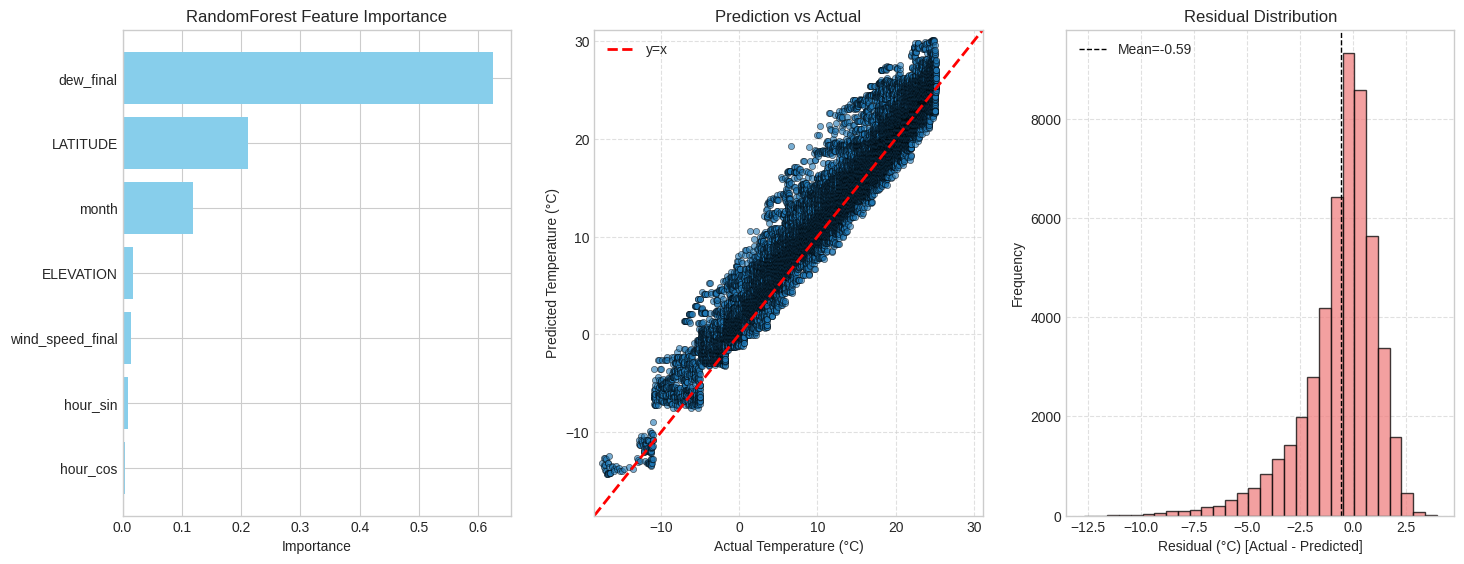


✅ Final Analysis Complete!


In [12]:
# === Cell 10: Final model analysis, comparison and visualisation ===
print("=== 10: Final Model Analysis, Comparison & Visualization ===")

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pyspark.ml.tuning import CrossValidatorModel
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
import builtins

# --- 1. Collect the results for all models ---
results = {
    "LinearRegression": {
        "rmse": lr_rmse,
        "r2": lr_r2,
        "mae": lr_mae,
        "time": lr_training_time,
        "model_path": "lr_cv_model", # Path for saved models
        "predictions": lr_predictions # Test set prediction results DataFrame
    },
    "RandomForest": {
        "rmse": rf_rmse,
        "r2": rf_r2,
        "mae": rf_mae,
        "time": rf_training_time,
        "model_path": "rf_cv_model",
        "predictions": rf_predictions
    }
    # ,"GBT": {
    #     "rmse": gbt_rmse,
    #     "r2": gbt_r2,
    #     "mae": gbt_mae,
    #     "time": gbt_training_time,
    #     "model_path": "gbt_cv_model",
    #     "predictions": gbt_predictions
    # }
}

# --- 2. Model Comparison ---
print("\n--- Model Performance Comparison ---")
print(f"{'Model':<20} {'RMSE (°C)':<12} {'R²':<10} {'MAE (°C)':<12} {'Time (s)':<10} {'RMSE vs LR':<15}")
print("-" * 75)

baseline_rmse = results["LinearRegression"]['rmse']
for name, metrics in results.items():
    improvement = (baseline_rmse - metrics['rmse']) / baseline_rmse * 100 if baseline_rmse != 0 else 0
    print(f"{name:<20} {metrics['rmse']:.4f}     {metrics['r2']:.4f}   {metrics['mae']:.4f}     {metrics['time']:.1f}      {improvement:+.1f}%")

# --- 3. Select the optimal model ---
best_model_name = builtins.min(results, key=lambda k: results[k]['rmse'])
best_metrics = results[best_model_name]
print(f"\n Best Model: {best_model_name} (RMSE: {best_metrics['rmse']:.4f}°C)")

# --- 4. Load the optimal model and analyse ---
print(f"\n--- Analyzing Best Model: {best_model_name} ---")
best_cv_model = CrossValidatorModel.load(best_metrics['model_path'])
best_pipeline_model = best_cv_model.bestModel # PipelineModel
actual_best_model = best_pipeline_model.stages[-1] # Acquire the actual model (LR, RF, or GBT)

# Optimal parameters
print("\nBest Hyperparameters:")
if isinstance(actual_best_model, LinearRegression):
    print(f"  regParam: {actual_best_model.getRegParam()}")
    print(f"  elasticNetParam: {actual_best_model.getElasticNetParam()}")
    print(f"  maxIter: {actual_best_model.getMaxIter()}")
elif isinstance(actual_best_model, RandomForestRegressor):
    print(f"  numTrees: {actual_best_model.getNumTrees}") 
    print(f"  maxDepth: {actual_best_model.getMaxDepth}") 
    # print(f"  maxBins: {actual_best_model.getMaxBins}") 
elif isinstance(actual_best_model, GBTRegressor):
    print(f"  maxIter: {actual_best_model.getMaxIter()}")
    print(f"  maxDepth: {actual_best_model.getMaxDepth()}")
    print(f"  stepSize: {actual_best_model.getStepSize()}")

# Feature Importance Analysis (requires the final_features list to be available in the current scope)
print("\nFeature Importance:")
feature_importances_data = []
if hasattr(actual_best_model, 'coefficients'): # Linear Regression
    coeffs = actual_best_model.coefficients.toArray()
    feature_importances_data = list(zip(final_features, np.abs(coeffs)))
    print(f"  Intercept: {actual_best_model.intercept:.4f}")
    importance_label = "Absolute Coefficient"
elif hasattr(actual_best_model, 'featureImportances'): # Tree models
    importances = actual_best_model.featureImportances.toArray()
    feature_importances_data = list(zip(final_features, importances))
    importance_label = "Importance"
else:
    print("  Cannot extract feature importance for this model type.")

if feature_importances_data:
    # Sort and print
    feature_importances_data.sort(key=lambda x: x[1], reverse=True)
    for feature, imp in feature_importances_data:
        print(f"  {feature}: {imp:.4f}")

    # --- 5. Visualizing analytics ---
    print("\n--- Visualizing Best Model Performance ---")

    # Obtain the prediction results from the optimal model
    best_predictions_df = best_metrics['predictions']

    # Convert to Pandas (sample to avoid memory issues if the test set is large)
    # If the test set is not large (e.g., a few thousand lines), sampling may be omitted
    sample_fraction = 0.5 if test_featured.count() > 10000 else 1.0 
    # pred_pd = best_predictions_df.select("TMP_value", "prediction").sample(fraction=sample_fraction, seed=42).toPandas()
    pred_pd = best_predictions_df.select("TMP_value", "prediction").limit(50000).toPandas()
    

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(15, 6))

    # Figure 1: Feature Importance
    if feature_importances_data:
        plt.subplot(1, 3, 1)
        features_plot = [f[0] for f in feature_importances_data]
        importances_plot = [f[1] for f in feature_importances_data]
        plt.barh(features_plot, importances_plot, color='skyblue')
        plt.xlabel(importance_label)
        plt.title(f'{best_model_name} Feature Importance')
        plt.gca().invert_yaxis() # Keep the most important ones at the top

    # Figure 2: Predicted vs Actual Values
    plt.subplot(1, 3, 2)
    plt.scatter(pred_pd['TMP_value'], pred_pd['prediction'], alpha=0.6, s=20, edgecolors='k', linewidths=0.5)
    min_val = builtins.min(pred_pd['TMP_value'].min(), pred_pd['prediction'].min()) - 1 
    max_val = builtins.max(pred_pd['TMP_value'].max(), pred_pd['prediction'].max()) + 1 
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='y=x')
    plt.xlabel('Actual Temperature (°C)')
    plt.ylabel('Predicted Temperature (°C)')
    plt.title('Prediction vs Actual')
    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # Figure 3: Residual Distribution
    plt.subplot(1, 3, 3)
    residuals = pred_pd['TMP_value'] - pred_pd['prediction']
    plt.hist(residuals, bins=30, alpha=0.75, color='lightcoral', edgecolor='black')
    plt.axvline(residuals.mean(), color='k', linestyle='dashed', linewidth=1, label=f'Mean={residuals.mean():.2f}')
    plt.xlabel('Residual (°C) [Actual - Predicted]')
    plt.ylabel('Frequency')
    plt.title('Residual Distribution')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout(pad=2.0) 
    plt.savefig(f'{best_model_name}_analysis.png', dpi=150) 
    print(f"\n Analysis plots saved to: {best_model_name}_analysis.png")
    plt.show()

else:
    print("\nNo visualization generated as feature importance could not be extracted.")


print("\n✅ Final Analysis Complete!")